#Q-Learning Trading Agent


###Market data retrieval

In [1]:
import zipline
import talib
start_date='2015-02-18'
end_date='2016-02-18'
data = get_pricing(
    ['SPY'],
    start_date=start_date,
    end_date = end_date,
    frequency='minute'
)
print data.price.head()
print data.price.tail()
#asset_data = data.price.loc[start_date].rename(columns={data.price.columns[0]: 'SPY'})
asset_data = data.price.rename(columns={data.price.columns[0]: 'SPY'})
prices=asset_data.SPY.as_matrix()
macd_raw, macd_signal, macd_hist =  talib.MACD(prices, fastperiod=12,slowperiod=26,signalperiod=9)
asset_data['macd_raw']=macd_raw
asset_data['macd_signal']=macd_signal
asset_data['macd_hist']=macd_hist
bb_upper, bb_middle, bb_lower = talib.BBANDS(prices,timeperiod=12,nbdevup=2,nbdevdn=2,matype=0)
asset_data['bb_upper']=bb_upper
asset_data['bb_middle']=bb_middle
asset_data['bb_lower']=bb_lower
rsi =talib.RSI(prices, timeperiod=7)
asset_data['rsi']=rsi
print asset_data.head()
print asset_data.tail()

                           Equity(8554 [SPY])
2015-02-18 14:31:00+00:00              209.59
2015-02-18 14:32:00+00:00              209.60
2015-02-18 14:33:00+00:00              209.61
2015-02-18 14:34:00+00:00              209.55
2015-02-18 14:35:00+00:00              209.59
                           Equity(8554 [SPY])
2016-02-18 20:56:00+00:00            191.9199
2016-02-18 20:57:00+00:00            191.9850
2016-02-18 20:58:00+00:00            192.0200
2016-02-18 20:59:00+00:00            191.9650
2016-02-18 21:00:00+00:00            192.0400
                              SPY  macd_raw  macd_signal  macd_hist  bb_upper  \
2015-02-18 14:31:00+00:00  209.59       NaN          NaN        NaN       NaN   
2015-02-18 14:32:00+00:00  209.60       NaN          NaN        NaN       NaN   
2015-02-18 14:33:00+00:00  209.61       NaN          NaN        NaN       NaN   
2015-02-18 14:34:00+00:00  209.55       NaN          NaN        NaN       NaN   
2015-02-18 14:35:00+00:00  209.59       NaN

###Data exploration

In [40]:
print asset_data.describe(percentiles=[0.5]).transpose()

               count        mean        std         min     50%         max
SPY          98310.0  204.457093   7.690784  181.040000  207.67  213.720000
macd_raw     98277.0   -0.001262   0.117318   -3.628914     NaN    1.049916
macd_signal  98277.0   -0.001258   0.110243   -2.948773     NaN    0.905086
macd_hist    98277.0   -0.000004   0.035887   -1.581692     NaN    0.701948
bb_upper     98299.0  204.650753   7.615652  181.560667     NaN  213.833976
bb_middle    98299.0  204.457503   7.689022  181.307492     NaN  213.626250
bb_lower     98299.0  204.264254   7.768967  177.773093     NaN  213.510606
rsi          98303.0   50.263723  16.317072    1.290005     NaN   98.380043


In [4]:
import matplotlib.pyplot as plt
def plot_data(day,data,transactions=None):
    #spy_price_data.fillna(0,inplace=True)
    textsize = 9
    left, width = 0.1, 0.8
    rect1 = [left, 0.7, width, 0.2]
    rect2 = [left, 0.3, width, 0.4]
    rect3 = [left, 0.1, width, 0.2]
    fig = plt.figure(facecolor='white')
    ax1 = fig.add_axes(rect1)
    ax2 = fig.add_axes(rect2,sharex=ax1)
    ax3 = fig.add_axes(rect3,sharex=ax1)
    ax1.set_title(day)
    # plot the relative strength indicator
    ax1.plot(data.index,data['rsi'])
    ax1.set_xlim(data.index[0],data.index[-1])
    ax1.legend()
    #plot price and bollinger band in the 2nd axes            
    ax2.plot(data.index, data['SPY'])
    color=''
    ax2.plot(data.index,data['bb_upper'],color='grey',lw=0.5)
    ax2.plot(data.index,data['bb_middle'],color='grey',lw=0.5)
    ax2.plot(data.index,data['bb_lower'],color='grey',lw=0.5)
    if transactions is not None:
        for i in range(0, len(transactions),2):
            if (i+1)<len(transactions):
                entry=transactions[i]
                exit=transactions[i+1]
                entry_price=entry['price']
                exit_price=exit['price']
                entry_amount=entry['amount']
                if (exit_price-entry_price)*entry_amount>0:
                    color='green'
                else:
                    color = 'red'
                ax2.plot([entry['dt'].time(),exit['dt'].time()],[entry['price'],exit['price']],color=color,linestyle='--')
    ax2.yaxis.tick_right()
    ax2.legend()
    # plot the MACD indicator
    ax3.plot(data.index,data['macd_raw'])
    ax3.plot(data.index,data['macd_signal'])
    ax3.fill_between(data.index,data['macd_hist'], 0, alpha=0.5)
    ax3.legend()
    for ax in ax1, ax2,ax3:
        if ax != ax3:
            for label in ax.get_xticklabels():
                label.set_visible(False)
        else:
            for label in ax.get_xticklabels():
                label.set_rotation(30)
                label.set_horizontalalignment('right')
    plt.show()

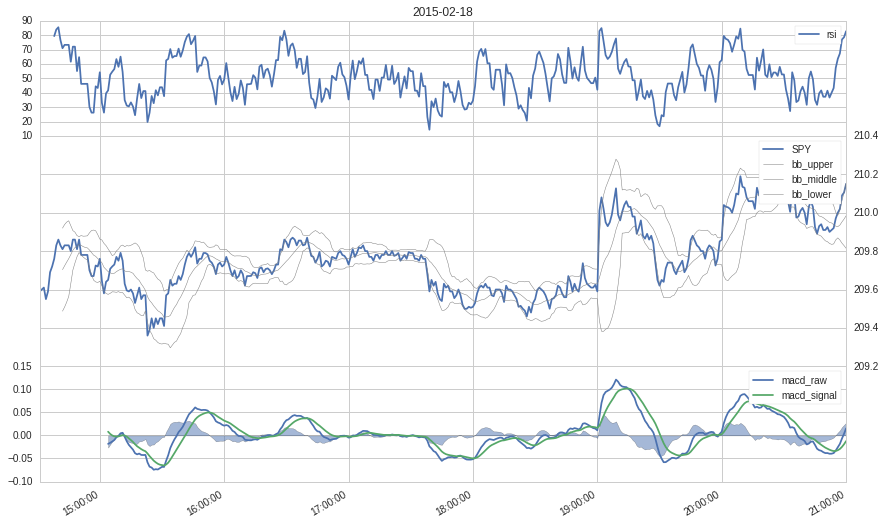

In [5]:
plot_data(start_date,asset_data.loc[start_date])

### Trading agent implementation

In [6]:
class SelfLearningTradingAgent():
    def __init__(self):
        self.available_actions=['none','long','short','close']
        self.allowed_actions={
            'long':['none','close'],
            'short':['none','close'],
            'none':['none','long','short']}
        self.rewards=[0]
        self.number_of_episodes=0
        self.previous_reward=0
        #The following flag is only true in the update step following a close action
        self.position_closed=False
    def init_new_episode(self):
        pass
    def learn(self,state,reward,action):
        pass
    def update(self,context,state):
        reward = self.get_reward(context)
        self.rewards.append(self.rewards[-1]+reward)
        next_action = self.choose_next_action(state)
        self.act(context,next_action)
        self.learn(state,reward,next_action)
    def choose_next_action(self,context,state):
        pass
    def act(self,context,action):
        if  context.trading_stopped is True:
            #Close any open trade towards the end of a trading day 
            if  context.portfolio.positions[context.SPY].amount!=0:
                order_target(context.SPY, 0)
            return
        if action == 'close':
            order_target(context.SPY, 0)
            context.position= 'none'
            self.position_closed=True
        if action == 'long':
            order_target(context.SPY, 100)
            context.position= 'long'
        if action == 'short':
            order_target(context.SPY, -100)
            context.position= 'short'
    def get_reward(self,context):
        if self.position_closed is True:
            self.position_closed=False
            return self.previous_reward
        if  context.portfolio.positions[context.SPY].amount!=0:
            current_price=context.portfolio.positions[context.SPY].last_sale_price
            original_price=context.portfolio.positions[context.SPY].cost_basis
            amount=context.portfolio.positions[context.SPY].amount
            self.previous_reward=(current_price-original_price)*np.sign(amount)
            return self.previous_reward
        return 0

In [7]:
from numpy import random
class MonkeyTrader(SelfLearningTradingAgent):
    def choose_next_action(self,state):
        return random.choice(self.allowed_actions[state['position']])

In [8]:
import numpy as np
import scipy
random.seed(40)
class QLearningTrader(SelfLearningTradingAgent):
    def __init__(self,alpha,gamma):
        SelfLearningTradingAgent.__init__(self)
        self.alpha=alpha
        self.gamma=gamma
        #The Q-table is represented by a pandas.DataFrame. 
        #This may be not the most memory-efficient solution, 
        #since the DataFrame will contain cells for actions that are not allowed in certains states
        #and are therefore never needed nor used and set to NaN.
        #A pandas.DataFrame does however provide rich and convenient functionalities that can be used to analyse the Q-table 
        #which more than justifies some waste of memory in a research setting.
        self.q_table=pd.DataFrame(columns=self.available_actions)
        self.previous_state=None
        self.previous_action=None
    def init_new_episode(self):
        self.previous_state=None
        self.previous_action=None
    def get_epsilon(self):
        return 0.1
    def extend_q_table_for(self,state):
        #Set q values for new state to NaN for all actions
        self.q_table.loc[str(state)] = [np.NaN]*len(self.available_actions)
        #initialize q values of allowed actions for new state with 0
        allowed_actions = self.allowed_actions[state['position']]
        [self.q_table.set_value(str(state),action,0) for action in allowed_actions]
    def get_actions_with_maximal_q_values_for(self,state):
        return self.q_table.ix[:,self.q_table.ix[str(state)] == self.q_table.ix[str(state)].dropna().max()].columns.tolist()
    def get_q_value(self,state,action):
        if str(state) not in self.q_table.index:
            self.extend_q_table_for(state)
        return self.q_table.loc[str(state),action]
    def set_q_value(self,state,action,q_value):
        self.q_table.loc[str(state),action]=q_value
    def choose_next_action(self,state):
        actions=[]
        if scipy.stats.bernoulli.rvs(1-self.get_epsilon()):
            if str(state) not in self.q_table.index:
                self.extend_q_table_for(state)
            actions = self.get_actions_with_maximal_q_values_for(state)
        else:
            actions= list(self.allowed_actions[state['position']])   
        return random.choice(actions)
    def learn(self,state,reward,action):
        if self.previous_action is not None:
            #The bellman equation
            new_q_value=(1-self.alpha)*self.get_q_value(self.previous_state,self.previous_action)+self.alpha*(reward+self.gamma*max([self.get_q_value(state,act) for act in self.allowed_actions[state['position']]])) 
            self.set_q_value(self.previous_state, self.previous_action,new_q_value)
        self.previous_action = action
        self.previous_state = state        

### Environment implementation

In [9]:
def do_thirty_minutes_before_session_ends(context, data):
    context.trading_stopped=True

In [10]:
def initialize(context):
    context.data_to_record=['SPY',
                            'macd_raw',
                            'macd_signal',
                            'macd_hist',
                            'bb_upper',
                            'bb_middle',
                            'bb_lower',
                            'rsi',
                            'state']
    context.position='none'
    context.trading_stopped=False
    #A step counter, used to skip the first few minutes and to support larger update steps (5 mins, 10 mins, etc)
    context.i = 0
    #The symbol represention of the SPY
    context.SPY = symbol('SPY')
    schedule_function(do_thirty_minutes_before_session_ends,date_rules.every_day(),time_rules.market_close(minutes=30))
    #A dictionary that will eventually contain a panda.DataFrame with relevant data for each trading day. 
    #This data will be used for post-algorithm analysis.
    #Note: The 'record' function provided by the Quantopian research environment is not sufficient in this case, 
    #      since it only allows recording with a daily resolution
    context.data={}          

In [11]:
#The complete state definition, which is used to derive the subset of state resulting in the highest total reward
import copy
complete_state=['rsi>70',
            'rsi<30',
            'macd_hist_positive',
            'macd_hist_negative',
            'upper_bband_up',
            'lower_bband_down']
#This method is called at every update step, to derive the current state from the indicator series. 
#The subset of states used by a specific Q-learner is defined by context.sub_state,
#such that it can be set from outside in the refinement step
def create_state(context,price,macd_raw,macd_signal,macd_hist,bb_upper,bb_middle,bb_lower,rsi):
    state=copy.copy(context.sub_state)
    state.append('position')
    full_state_dict={'position':context.position,
                     'rsi>70':rsi[-1]>70,
                     'rsi<30':rsi[-1]<30,
                     'macd_hist_positive':macd_hist[-1]>0,
                     'macd_hist_negative':macd_hist[-1]<0,
                     'upper_bband_up': (bb_upper[-1]-bb_upper[-2])>0,
                     'lower_bband_down': (bb_lower[-1]-bb_lower[-2])<0}
    substate = dict([(k,v) for (k,v) in  full_state_dict.iteritems() if k in state])
    return substate

In [12]:
#A method which is called every trading day befor trading start
def before_trading_start(context, data):
    context.trading_stopped=False
    context.today=get_datetime().date().isoformat()
    context.data[context.today]=pd.DataFrame(columns=context.data_to_record)
    context.trading_agent.init_new_episode()

In [13]:
#The central update function, which is called every minute by the Quantopian runtime engine
def handle_data(context, data):
    context.i=context.i+1
    #Wait for 40 minutes on the first day, to get enough historical prices for the indicators
    if context.i<40:
        return
    prices = data.history(context.SPY, 'price', 40, '1m')
    current_time=prices.index[-1].time()
    prices_array=prices.as_matrix()
    macd_raw, macd_signal, macd_hist =  talib.MACD(prices_array, fastperiod=12,slowperiod=26,signalperiod=9)
    bb_upper, bb_middle, bb_lower = talib.BBANDS(prices_array,timeperiod=12,nbdevup=2,nbdevdn=2,matype=0)
    rsi =talib.RSI(prices_array, timeperiod=7)
    state=create_state(context,
                       prices,
                       macd_raw,
                       macd_signal,
                       macd_hist,
                       bb_upper,
                       bb_middle,
                       bb_lower,
                       rsi)
    context.data[context.today].loc[current_time]=dict(zip(context.data_to_record,
                                                           [prices[-1],
                                                            macd_raw[-1],
                                                            macd_signal[-1],
                                                            macd_hist[-1],
                                                            bb_upper[-1],
                                                            bb_middle[-1],
                                                            bb_lower[-1],
                                                            rsi[-1],
                                                            state]))
    context.trading_agent.update(context,state)

### Model Evaluation and Validation

In [14]:
import zipline
from zipline import TradingAlgorithm
from zipline.api import order_target, record, symbol,schedule_function,date_rules,time_rules,get_datetime
from datetime import datetime
#Method to analyze the results of a trading algorithm. 
def analyze(context, perf):
    perf_trans = perf.ix[[t != [] for t in perf.transactions]]
    perf_trans.transactions.index=perf_trans.transactions.index.date
    trading_days= [pd.to_datetime(day).date() for day in context.data.keys()]
    trading_days.sort()
    for day in [trading_days[0]]+trading_days[-3:]:
        transactions = perf_trans.transactions[day]
        transactions.sort(key=lambda d: d['dt'])
        plot_data(day,context.data[day.isoformat()], transactions)

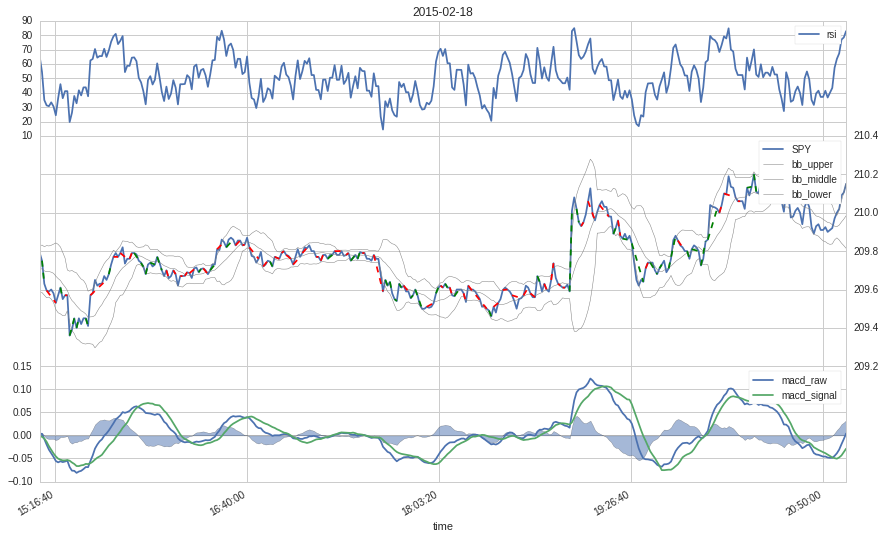

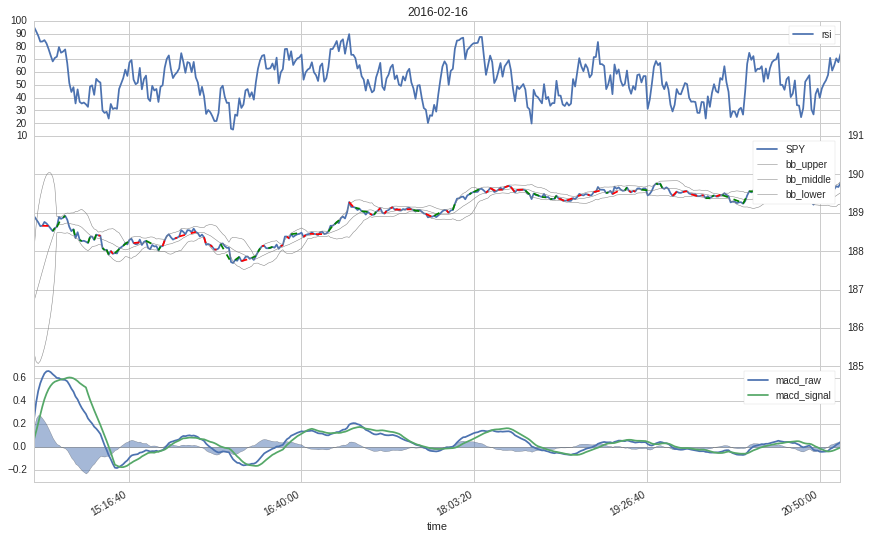

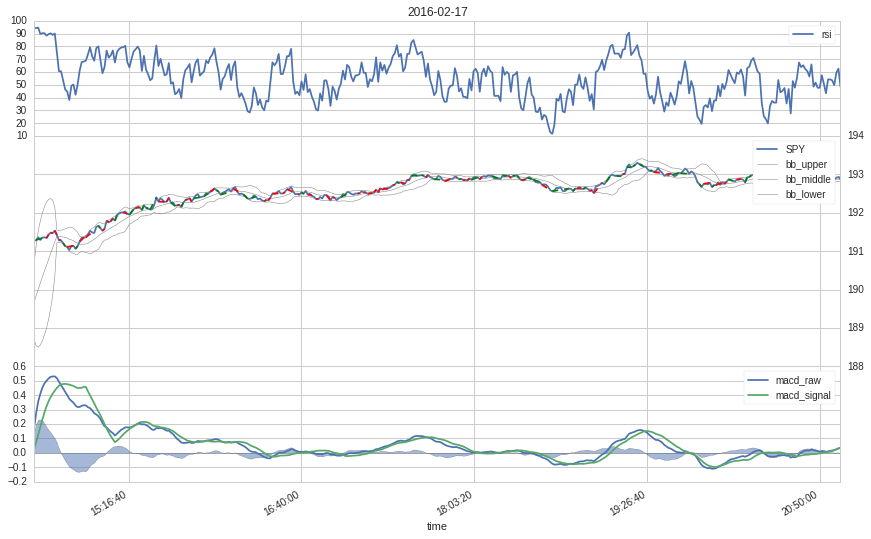

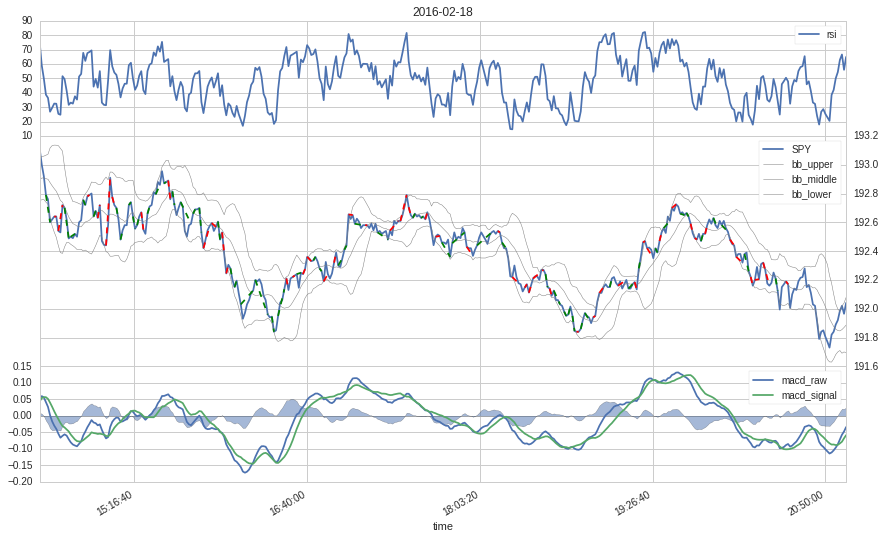

-787.69954172


In [15]:
#Snippet to setup, run and analyze the trading algorithm for the monkey trader
random.seed(40)
monkey_trading_algorithm = TradingAlgorithm(
    initialize=initialize, 
    handle_data=handle_data,
    before_trading_start=before_trading_start
)
monkey_trading_algorithm.trading_agent=MonkeyTrader()
monkey_trading_algorithm.sub_state=[]
monkey_trading_algorithm._analyze = analyze
perf_manual=monkey_trading_algorithm.run(data.transpose(2,1,0))
print monkey_trading_algorithm.trading_agent.rewards[-1]

In [16]:
#The following code iterates through the power set of the complete state definition 
#and constructs and runs a Q-learning trader for each subset of states.
#The results are reported below.
import itertools
state_results=pd.Series()
highest_reward=None
best_state_combination=[]
for sub_state in itertools.chain.from_iterable(itertools.combinations(complete_state, r) for r in range(len(complete_state)+1)):
    random.seed(40)
    q_learning_trading_algorithm = TradingAlgorithm(
    initialize=initialize, 
    handle_data=handle_data,
    before_trading_start=before_trading_start)
    q_learning_trading_algorithm.sub_state=list(sub_state)
    q_learning_trading_algorithm.trading_agent=QLearningTrader(alpha=0.2,gamma=0.8)
    perf_manual = q_learning_trading_algorithm.run(data.transpose(2,1,0))
    total_reward=q_learning_trading_algorithm.trading_agent.rewards[-1]
    print "State combination:  {}  reward: {}".format(q_learning_trading_algorithm.sub_state, total_reward)
    if highest_reward is None or total_reward>highest_reward:
        highest_reward=total_reward
        best_state_combination=list(sub_state)
    state_results[str(sub_state)]= total_reward

State combination:  []  reward: -95.4961074638
State combination:  ['rsi>70']  reward: -119.888923227
State combination:  ['rsi<30']  reward: -117.679674886
State combination:  ['macd_hist_positive']  reward: -80.8519895623
State combination:  ['macd_hist_negative']  reward: -80.8519895623
State combination:  ['upper_bband_up']  reward: -81.6766367818
State combination:  ['lower_bband_down']  reward: -105.95224508
State combination:  ['rsi>70', 'rsi<30']  reward: -109.134115919
State combination:  ['rsi>70', 'macd_hist_positive']  reward: -52.3379546332
State combination:  ['rsi>70', 'macd_hist_negative']  reward: -52.3379546332
State combination:  ['rsi>70', 'upper_bband_up']  reward: -112.149752683
State combination:  ['rsi>70', 'lower_bband_down']  reward: -39.8736455629
State combination:  ['rsi<30', 'macd_hist_positive']  reward: -121.753510099
State combination:  ['rsi<30', 'macd_hist_negative']  reward: -121.753510099
State combination:  ['rsi<30', 'upper_bband_up']  reward: -74

In [17]:
state_results.sort(ascending=False)
print "The 5 best state combinations are:"
print state_results.iloc[:5]

The 5 best state combinations are:
('rsi>70', 'lower_bband_down')                           -39.873646
('rsi>70', 'macd_hist_positive', 'macd_hist_negative')   -52.337955
('rsi>70', 'macd_hist_positive')                         -52.337955
('rsi>70', 'macd_hist_negative')                         -52.337955
('rsi<30', 'upper_bband_up', 'lower_bband_down')         -62.569670
dtype: float64


In [18]:
print "The best state combination is: {} ".format(best_state_combination)

The best state combination is: ['rsi>70', 'lower_bband_down'] 


In [20]:
#The following code performs a grid search through the parameter space of alpha and gamma
#and constructs and runs a Q-learning trader for combination, usind the best_state_combination. 
parameter_results=pd.DataFrame()
best_algorithm=None
for alpha in np.arange(0.1,1,0.1):
    for gamma in np.arange(0.1,1,0.1):
        random.seed(40)
        q_learning_trading_algorithm = TradingAlgorithm(
            initialize=initialize, 
            handle_data=handle_data,
            before_trading_start=before_trading_start)
        q_learning_trading_algorithm.sub_state=best_state_combination
        q_learning_trading_algorithm.trading_agent=QLearningTrader(alpha=alpha,gamma= gamma)
        perf_manual = q_learning_trading_algorithm.run(data.transpose(2,1,0))
        total_reward=q_learning_trading_algorithm.trading_agent.rewards[-1]
        print "alpha:  {} gamma: {} reward: {}".format(alpha,gamma, total_reward)
        parameter_results.loc[alpha,gamma]=total_reward
        if best_algorithm is None or total_reward>best_algorithm[0].trading_agent.rewards[-1]:
            best_algorithm = (q_learning_trading_algorithm,perf_manual)

alpha:  0.1 gamma: 0.1 reward: -98.1991894427
alpha:  0.1 gamma: 0.2 reward: -115.352791407
alpha:  0.1 gamma: 0.3 reward: -111.033427589
alpha:  0.1 gamma: 0.4 reward: -115.364587805
alpha:  0.1 gamma: 0.5 reward: -87.9242835112
alpha:  0.1 gamma: 0.6 reward: -115.03408207
alpha:  0.1 gamma: 0.7 reward: -117.684077832
alpha:  0.1 gamma: 0.8 reward: -122.722643065
alpha:  0.1 gamma: 0.9 reward: -119.390860493
alpha:  0.2 gamma: 0.1 reward: -118.344425651
alpha:  0.2 gamma: 0.2 reward: -109.925823296
alpha:  0.2 gamma: 0.3 reward: -114.423498206
alpha:  0.2 gamma: 0.4 reward: -126.460236057
alpha:  0.2 gamma: 0.5 reward: -113.426942001
alpha:  0.2 gamma: 0.6 reward: -125.270842782
alpha:  0.2 gamma: 0.7 reward: -119.839931122
alpha:  0.2 gamma: 0.8 reward: -39.8736455629
alpha:  0.2 gamma: 0.9 reward: -80.6481319847
alpha:  0.3 gamma: 0.1 reward: -102.697384878
alpha:  0.3 gamma: 0.2 reward: -70.4423632453
alpha:  0.3 gamma: 0.3 reward: -111.416217056
alpha:  0.3 gamma: 0.4 reward: -96.

In [25]:
best_agent=best_algorithm[0].trading_agent
print "The highest reward of {} could be achieved with an alpha of {} and a gamma of {}.".format(best_agent.rewards[-1],
                                                                                                best_agent.alpha,
                                                                                                best_agent.gamma)

The highest reward of 9.2258773501 could be achieved with an alpha of 0.9 and a gamma of 0.7.


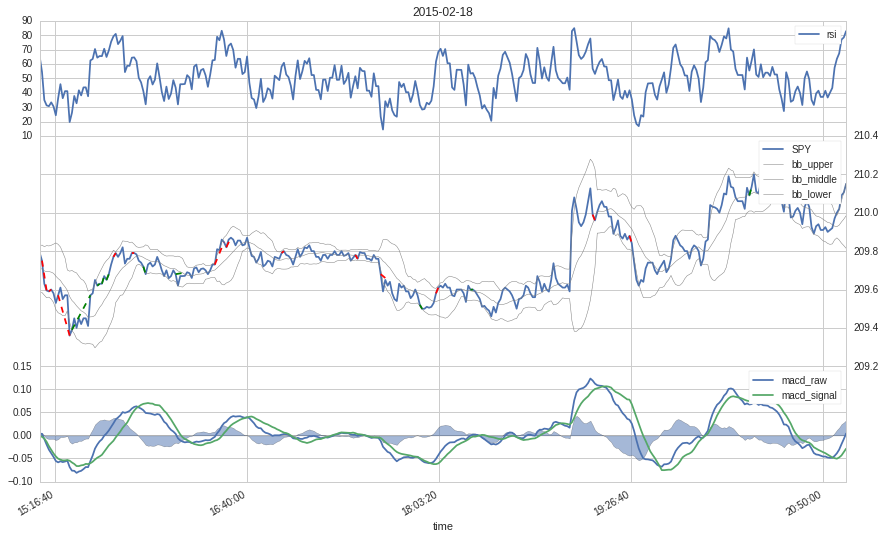

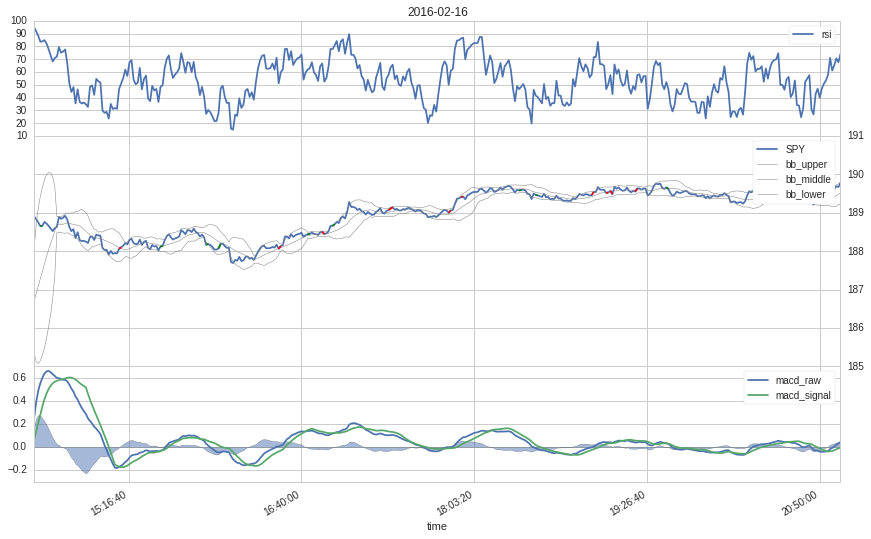

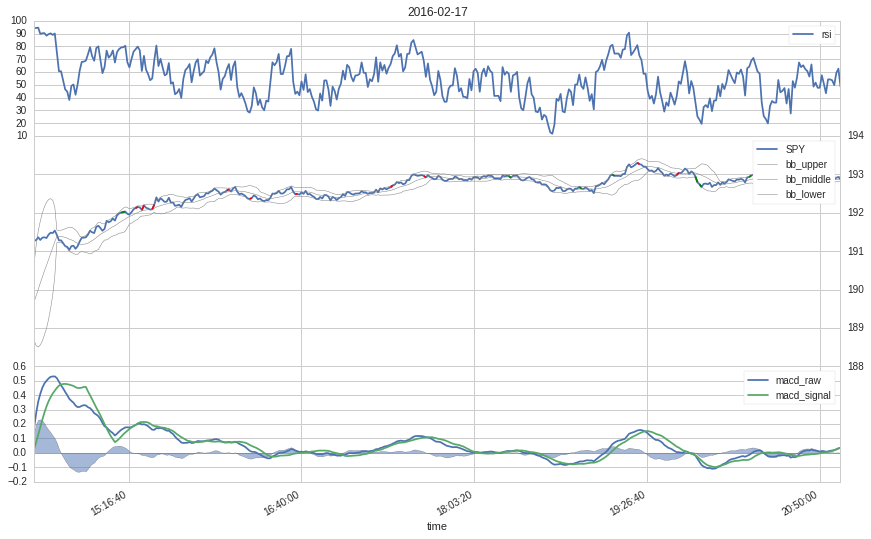

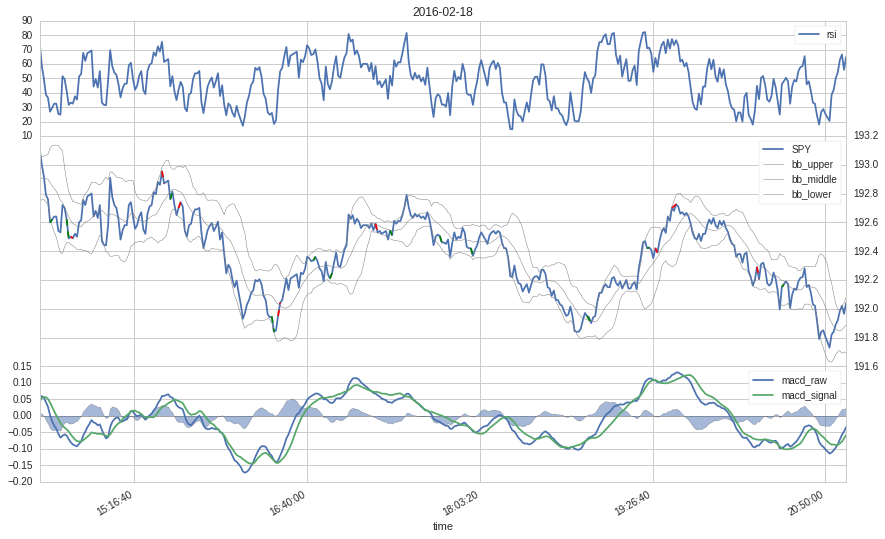

In [26]:
analyze(best_algorithm[0],best_algorithm[1])

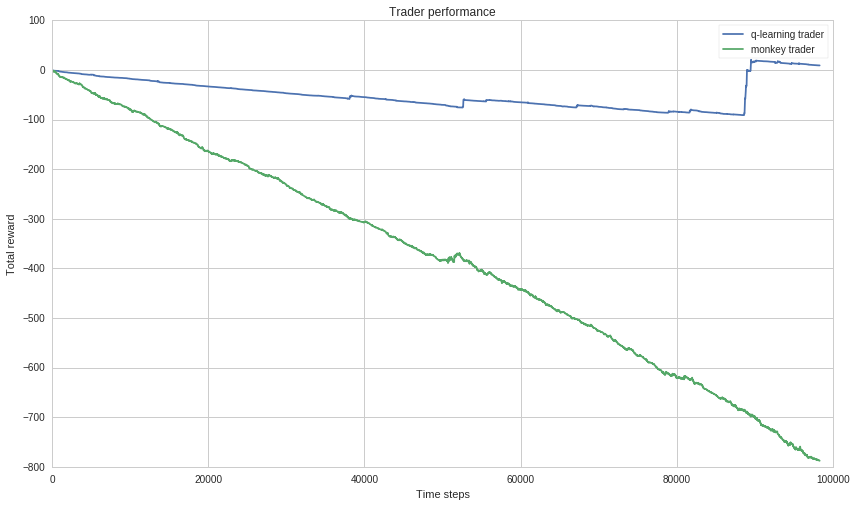

In [27]:
plt.plot( best_agent.rewards, label='q-learning trader')
plt.plot(monkey_trading_algorithm.trading_agent.rewards, label='monkey trader')
plt.title('Trader performance')
plt.xlabel('Time steps')
plt.ylabel('Total reward')
plt.legend(loc='upper right')

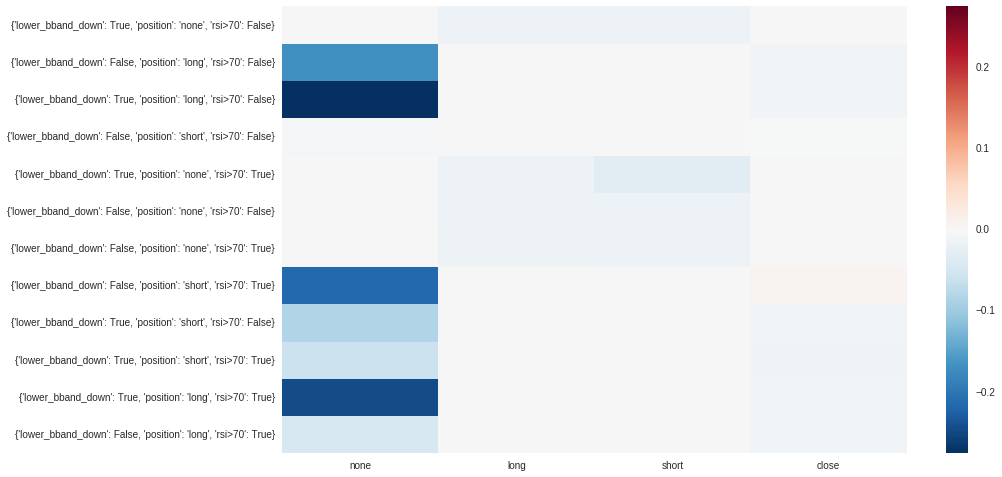

In [30]:
#The following code displays the Q-table of the best Q-learning agent as a heatmap
import seaborn as sns
q_table=best_agent.q_table.fillna(0)
sns.heatmap(q_table)

In [29]:
print "The shape of the q-table is: {}".format(q_table.shape)

The shape of the q-table is: (12, 4)


In [38]:
sorted_q_values = q_table.stack().sort(inplace=False)
print "The state/action pair with the largest q value {} is {}:".format(sorted_q_values[-1],sorted_q_values.index[-1])
print "The state/action pair with the lowest q value {} is {}:".format(sorted_q_values[0],sorted_q_values.index[0])

The state/action pair with the largest q value 0.00799953646556 is ("{'lower_bband_down': False, 'position': 'short', 'rsi>70': True}", 'close'):
The state/action pair with the lowest q value -0.275340896278 is ("{'lower_bband_down': True, 'position': 'long', 'rsi>70': False}", 'none'):
